
# 1) Intro — Multi-Agent Nutritionist (Two Models)

This workshop uses **two cooperating agents**:

- **Consultant (Medical Expert) — `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`**  
  Acts as the *brain* for our medical expert agent. It has access to a **local OpenNutrition DB** (ingredient/nutrition data + potential health warnings).  
  It **assesses the ingredients** of a provided food item and returns an expert analysis plus **healthier alternatives**.

- **Orchestrator (Vision + Retrieval) — `Qwen/Qwen3-VL-30B-A3B-Instruct-FP8`**  
  Accepts **images (labels/barcodes)** or **text**. Uses **OpenFoodFacts (OFF) API** tools to gather ingredients.  
  If OFF fails, it uses **EXA via MCP** as a fallback web search.  
  Finally, it **consults the expert agent** and produces a full analysis and suggested **healthier alternatives**.
  

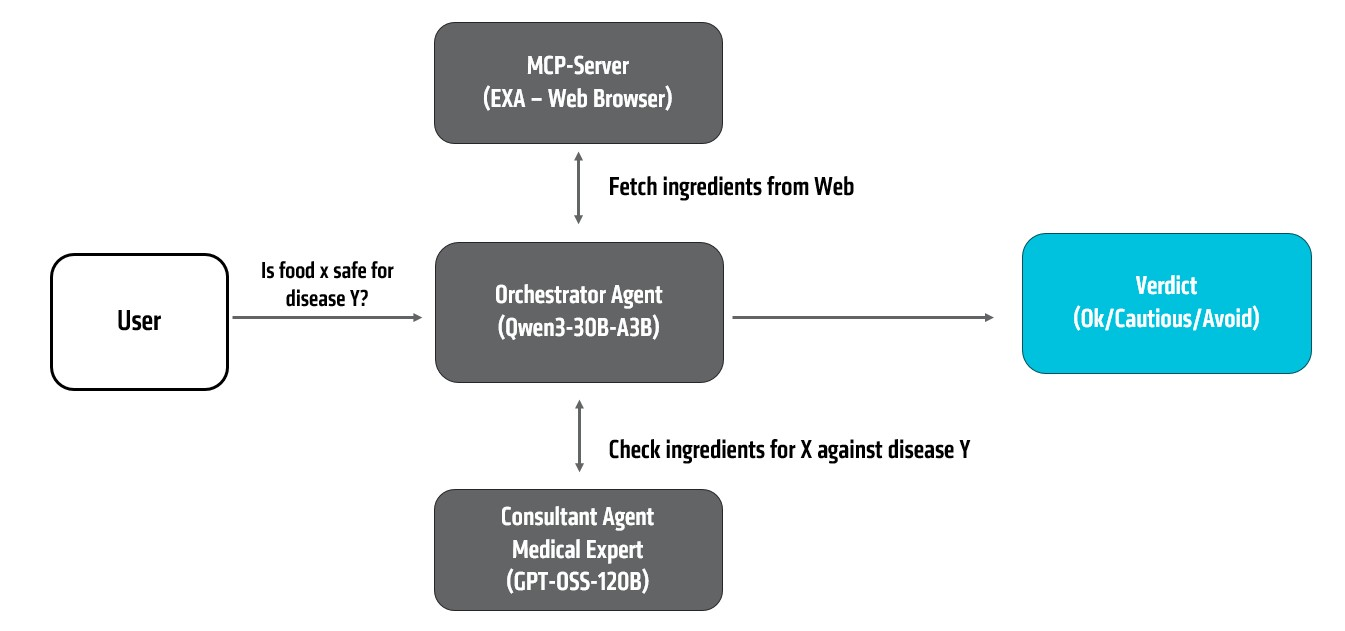


# 2) Flow, Goals, and Agenda

## Flow (High Level)
1. Orchestrator receives input (image/barcode/text) for a snack/food.
2. Orchestrator looks up **ingredients** using **OFF API**; if not found, uses **EXA (MCP)**.
3. Orchestrator passes clean ingredients (or product name) to **Consultant**.
4. Consultant evaluates risks, flags concerns, and proposes **healthier alternatives**.
5. Orchestrator returns a concise, user-friendly **verdict + reasons + alternatives**.

## What You Will Build
- A **Vision-capable Orchestrator agent** (Qwen VL) with tools for **OFF** and **EXA (MCP)**.
- A **Consultant agent** (Qwen 30B text) backed by a **local OpenNutrition DB** toolset.
- The **glue** that lets the Orchestrator consult the Consultant automatically.

## What You Will Learn
- Running **open-weights** models with **vLLM** and **tool calling**.
- Turning LLMs into **agents** using **Pydantic AI**.
- Turning a **local DB** into a **callable tool** for an AI agent.
- Turning an **external API** (OpenFoodFacts) into a **callable tool**.
- Connecting a **web browser** using **MCP** with **EXA**.
- Wiring up **two agents to collaborate** on one task.

## Agenda (You’ll fill in the code cells)
1. Pre-reqs
2. Install dependencies & imports
3. Verify model endpoints
4. Smoke test the **Consultant** model
5. Build **Consultant** agent + tools (local DB)
6. Build **Orchestrator** agent + tools (OFF + EXA fallback)
7. Glue: Orchestrator calls Consultant
8. E2E examples



# 3) Pre-reqs — Running Two Models with vLLM

Briefly describe your environment and GPU (e.g., AMD ROCm + MI300X).  
You will launch **two** model servers in separate terminals:

- **Consultant**: `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8` on **:9000**  
- **Orchestrator**: `Qwen/Qwen3-VL-30B-A3B-Instruct-FP8` on **:9001**

> Tip: Start them **sequentially** to avoid OOM.

Start both model endpoints in **separate terminals** so the Orchestrator and Consultant are available.

### Consultant (`Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`) on port **9000**




```bash
VLLM_ATTENTION_BACKEND=TORCH_SDPA \
VLLM_USE_TRITON_FLASH_ATTN=0 \
vllm serve Qwen/Qwen3-30B-A3B-Instruct-2507-FP8 \
  --port 9000 \
  --enable-auto-tool-choice \
  --tool-call-parser hermes \
  --trust-remote-code \
  --gpu-memory_utilization 0.45
```



### Orchestrator (`Qwen/Qwen3-VL-30B-A3B-Instruct-FP8`) on port **9001**
```bash
VLLM_USE_TRITON_FLASH_ATTN=0 \
vllm serve Qwen/Qwen3-VL-30B-A3B-Instruct-FP8 \
  --port 9001 \
  --enable-auto-tool-choice \
  --tool-call-parser hermes \
  --trust-remote-code \
  --gpu-memory_utilization 0.45
```



# 4) Install Pre-reqs and Imports

Let's installs all the libraries, then import what you need.  

In [ ]:
!pip -q install pydantic_ai openai httpx
# Download the ZIP file for local DB
!wget https://downloads.opennutrition.app/opennutrition-dataset-2025.1.zip -O opennutrition-dataset-2025.1.zip
# Unzip the file in the same directory
!unzip opennutrition-dataset-2025.1.zip -d ./ 

# ── Standard library ────────────────────────────────────────────────────────────
from pathlib import Path
from typing import List, Optional, Literal, Dict
import os, json, mimetypes

# ── Third-party ────────────────────────────────────────────────────────────────
import httpx
from openai import OpenAI
from pydantic_ai import Agent, Tool, BinaryContent
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.openai import OpenAIProvider
from pydantic_ai.mcp import MCPServerStdio

# ── Local/project modules ──────────────────────────────────────────────────────
from off_api import OFFClient
from tools_nutrition_local import reload_tsv, lookup_by_name_local

# ── Init ───────────────────────────────────────────────────────────────────────

reload_tsv("/workspace/opennutrition_foods.tsv")
print("Nutrition TSV loaded/reloaded for consultant.")


# 5) Verify Model Endpoints

Create a small helper that hits `/v1/models` for both servers.  
Confirm:
- **Qwen/Qwen3-30B-A3B-Instruct-2507-FP8:9000** — Consultant (text)
- **Qwen/Qwen3-VL-30B-A3B-Instruct-FP8:9001** — Orchestrator (vision)


In [ ]:
def check_endpoint(base_url: str) -> None:
    try:
        r = httpx.get(f"{base_url}/models", timeout=10.0)
        r.raise_for_status()
        models = r.json()
        print(f"[OK] {base_url} reachable. Models:", models.get("data", []) or models)
    except Exception as e:
        print(f"[WARN] Could not reach {base_url}: {e}")

check_endpoint("http://localhost:9000/v1")  # Consultant
check_endpoint("http://localhost:9001/v1")  # Orchestrator


# 6) Smoke Test — Consultant Model (Text)

Run a tiny prompt through the **Consultant** endpoint (**:9000**, `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`) and ensure you get output.


In [ ]:
consult_client = OpenAI(
    base_url="http://localhost:9000/v1",
    api_key="EMPTY",
    http_client=httpx.Client(http2=False),
)

try:
    resp = consult_client.chat.completions.create(
        model="Qwen/Qwen3-30B-A3B-Instruct-2507-FP8",
        messages=[
            {"role": "system", "content": "You are a helpful assistant. "},
            {"role": "user", "content": "Greet my audience to our multi-agent workshop where they build a nutrionist agent."}
        ],
        temperature=0.4,     # more informative but not too random
        max_tokens=512,      # allow a longer answer
    )
    print(resp.choices[0].message.content)
except Exception as e:
    print("[WARN] Consultant chat request failed:", e)

# 7) Build the Consultant Agent with Pydantic AI

Use **Pydantic AI** to turn the text model (`Qwen/Qwen3-30B-A3B-Instruct-2507-FP8` on :9000) into a structured **Consultant agent**.

**Goals**
- Define a concise **system prompt** (safety-first; JSON-only outputs).
- Create the agent bound to the **consultant endpoint**.
- Provide a tiny **async runner** helper to test the agent with a simple ingredient list.

**Hints**
- Keep the system prompt minimal and enforce JSON shape.
- Use short reasons (<= 12 words) for readability.
- Don’t browse in this agent; it relies on local DB/tooling and general nutrition knowledge.


In [ ]:
provider_consult = OpenAIProvider(base_url="http://localhost:9000/v1", api_key="EMPTY")
consultant_model = OpenAIChatModel("Qwen/Qwen3-30B-A3B-Instruct-2507-FP8", provider=provider_consult)

CONSULTANT_SYSTEM = """
You are a **Nutrition Consultant AI**.

### 1. Role
Evaluate food products or ingredient lists for a specific health goal. Recommend healthier alternatives from your tool local_lookup_by_name that taste similar and fit the same product type.

### 2. Input
You will receive either:
1) a product name, or 2) a list of ingredients, and a goal in {general_health, low_sodium, low_sugar, high_protein}.

### 3. Process
- If a **product name** is provided, use `local_lookup_by_name` to retrieve a record and ingredients; then analyze.
- If only **ingredients** are provided, analyze using domain knowledge, infer product type(cookie, soup, rice dish, potato chips, etc) and consider alternatives based on type.
- Find one healthier healther alternative by finding it using `local_lookup_by_name` that is from the same type(i.e if the product is soup, suggest a healther soup).
- Decide overall: ok | caution | avoid | uncertain. Keep reasons concise.
### 4. Rules
- If the alternative item you suggested is NOT found by `local_lookup_by_name` then keep trying until you find a healthier alternative that is found by this tool.

### 4. Output (JSON only)
{
  "product": "string | optional",
  "overall": "ok | caution | avoid | uncertain",
  "reasons": ["<=12 words each"],
  "warnings": ["<=12 words each"],
  "alternatives": [{"name": "string", "reason": "<=10 words"}],
  "notes": ["optional tip"],
  "disclaimer": "Educational only; not medical advice."
}
"""

consultant_agent = Agent(
    model=consultant_model,
    system_prompt=CONSULTANT_SYSTEM,
)

# 8) Add Local OpenNutrition DB as a Tool

Expose your **local OpenNutrition DB** functions as **agent tools** for the Consultant.

**Goals**
- Register a **name lookup** tool (and optionally a scored/assessed lookup).

In [ ]:
@consultant_agent.tool_plain
def local_lookup_by_name(name: str, top_k: int = 5):
    """Lookup product by name (uses name + alternate_names)."""
    res = lookup_by_name_local(name, top_k=top_k)
    return res if res else [{"status": "not_found"}]

async def run_consultant(prompt: str) -> str:
    async with consultant_agent:
        result = await consultant_agent.run(prompt)
        return result.output

print("Consultant agent ready.")


Now, let's try our agent. I am going to provide this agent the ingredients of Kimchi Fried Rice without telling it what dish this is. Let's see if the agent can infer the type of the dish and analyze it correctly.

In [ ]:

# Quick try
await run_consultant("Cooked rice, Kimchi, Gochujang (Korean red chili paste), Soy sauce, Sesame oil, Garlic, Green onions, Vegetable oil, Egg, Sugar, Sesame seeds, Seaweed flakes (optional)")


# 9) Orchestrator (Phase 1) – Ingredient Extractor (no tools yet)

Create a **Vision-capable Orchestrator** agent (`Qwen/Qwen3-VL-30B-A3B-Instruct-FP8` on :9001) **without tools** to start.

**Goals**
- Set a system prompt that **returns only a cleaned ingredient list** when given a product name or image.
- Keep responses brief (<= 5 lines).
- Ask **one clarifying question** if the query is ambiguous.

**Hints**
- This phase helps validate basic I/O with the VLM before wiring tools.
- You can test with text-only queries first.


In [ ]:
provider_orch = OpenAIProvider(base_url="http://localhost:9001/v1", api_key="EMPTY")
orch_model = OpenAIChatModel("Qwen/Qwen3-VL-30B-A3B-Instruct-FP8", provider=provider_orch)

ORCH_SYS_PHASE1 = """
You are an Ingredient Orchestrator.
Goal: When the user names a packaged snack, a dish, or provides a picture, return ONLY a cleaned ingredient list (bullets or comma‑separated) along with product name. If ambiguous, state one brief assumption.
Keep response ≤ 5 lines. Educational only; not medical advice.
"""

orchestrator_phase1 = Agent(model=orch_model, system_prompt=ORCH_SYS_PHASE1)

async with orchestrator_phase1:
    demo = await orchestrator_phase1.run("Ingredients for KitKat (USA)?")
    print(demo.output)

# 9) Enable EXA MCP (Fallback Web Search)

Add **EXA via MCP** as a **toolset** available to the Orchestrator for **ingredient retrieval** when OFF/local info is insufficient.

**Goals**
- Initialize `MCPServerStdio` with your `EXA_API_KEY` (environment variable).
- Attach the EXA toolset to the Orchestrator agent.

**Showcase**
- Demonstrate a case where **EXA** finds a manufacturer or retailer page with a clearer ingredient list than initial guesses.


Let's install necessary packages and set EXA MCP client.

In [ ]:
!curl -fsSL https://deb.nodesource.com/setup_20.x | sudo -E bash - || true
!apt-get install -y nodejs || true

EXA_API_KEY = os.environ.get("EXA_API_KEY")
exa_server = None
if EXA_API_KEY:
    exa_server = MCPServerStdio(
        "npx",
        args=["-y", "mcp-remote", f"https://mcp.exa.ai/mcp?exaApiKey={EXA_API_KEY}"],
    )
    print("EXA MCP enabled.")
else:
    print("EXA MCP disabled (set EXA_API_KEY to enable).")

Next, we will update our agent system prompt and `toolsets` parameter to use EXA.

In [ ]:
ORCH_SYS_PHASE1_EXA = """
You are an Ingredient Orchestrator with tool access.

Hard requirement:
• ALWAYS use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.
• Do not answer until you have called web_search_exa at least once in this turn.

Goal:
• When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
• Then list the ingredients and the name of the snack.
• Provide a link to the source.

Rules:
• Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
"""

orchestrator_phase1_exa = Agent(
    model=orch_model,
    system_prompt=ORCH_SYS_PHASE1_EXA,
    toolsets=[exa_server] if exa_server else None,
)


Let's try the agent with browsing enabled.

In [ ]:

async with orchestrator_phase1_exa:
    demo = await orchestrator_phase1_exa.run("Ingredients for KitKat (USA)?")
    print(demo.output)


# 10) Add OpenFoodFacts (OFF) Tools — Vision Barcode -> Ingredients

Turn the **OFF API** into callable tools for the Orchestrator:
- `off_by_barcode(ean_13: str) -> dict`
- `off_search_by_name(query: str, limit: int = 10) -> list[dict]`

**Goals**
- Register OFF tools on the Orchestrator.
- Show a **vision example**: read a label/barcode from an image, call `off_by_barcode`, and extract **ingredients**.


In [ ]:
off = OFFClient(user_agent="IngredientOrchestrator/1.0 (you@example.com)")

def off_by_barcode_fn(ean_13: str) -> dict:
    """OpenFoodFacts API: lookup by EAN‑13 barcode."""
    try:
        return off.product_by_barcode(ean_13) or {"status": "not_found"}
    except Exception as e:
        return {"status": "error", "error": str(e)}

def off_search_by_name_fn(query: str, limit: int = 10):
    """OpenFoodFacts API: search by name."""
    try:
        return off.search_by_name(query, limit=limit) or [{"status": "not_found"}]
    except Exception as e:
        return [{"status": "error", "error": str(e)}]

off_by_barcode = Tool(off_by_barcode_fn, name="off_by_barcode", description="OFF: lookup by barcode")
off_search_by_name = Tool(off_search_by_name_fn, name="off_search_by_name", description="OFF: search by name")

ORCH_SYS_PHASE1_EXA_OFF = """
You are an Ingredient Orchestrator with tool access.

Data tools (in required priority):
1. off_by_barcode(ean_13)  -> FIRST if a 13-digit barcode is present.
2. off_search_by_name(name) -> If no barcode or barcode lookup failed.
3. use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.

Goal:
• When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
• Then list the ingredients and the name of the snack.
• Provide a link to the source.

Rules:
• Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
"""

orchestrator_phase1_exa_off = Agent(
    model=orch_model,
    system_prompt=ORCH_SYS_PHASE1_EXA_OFF,
    tools=[off_by_barcode, off_search_by_name],
    toolsets=[exa_server] if exa_server else None,
)

We can now try our VLM, by giving it a picture rather than the name or ingredients. Let's start by making sure the picture we are giving it is a relevant picture.

In [ ]:
img_path = Path("barcode.jpg")
if img_path.exists():
    # Preview the image (fast, no Pillow needed)
    from IPython.display import display, Image as IPImage
    display(IPImage(filename=str(img_path)))  # shows the picture inline
else:
    print("[Info] Sample image not found; skipping image demo.")

Now let's see if our agent can extract the barcode and pass it to its barcode reader tool.

In [ ]:

# Image example (if file exists)
img_path = Path("barcode.jpg")
if img_path.exists():
    mime = mimetypes.guess_type(str(img_path))[0] or "image/jpeg"
    content = [
        "Use the image: extract a barcode (remove all spaces and extra chars); and call off_by_barcode or off_search_by_name to list ingredients.",
        BinaryContent(data=img_path.read_bytes(), media_type=mime),
    ]
    async with orchestrator_phase1_exa_off:
        demo = await orchestrator_phase1_exa_off.run(content)
        print(demo.output)
else:
    print("[Info] Sample image not found; skipping image demo.")


# 11) Wrap Consultant as a Tool

Expose the Consultant as a callable tool (e.g., `consult_nutritionist(...)`.

**Goals**
- Accept **product name** or **ingredient list** and an optional **goal** (e.g., `low_sodium`).
- Call the **Consultant agent** internally and **parse JSON** safely.
- Return a minimal **fallback** JSON if the consultant returns malformed data.


In [ ]:
from typing import Optional

async def consult_nutritionist_fn(
    ingredients: List[str],
    sodium_mg_per_serving: Optional[int] = None,
    product_name: Optional[str] = None,
) -> dict:
    print("consultant agent is called")
    payload = {"product_name": product_name, "ingredients": ingredients}

    async with consultant_agent:
        res = await consultant_agent.run(json.dumps(payload))

    try:
        return json.loads(res.output)
    except Exception:
        return {
            "overall": "uncertain",
            "reasons": ["consultant returned non‑JSON"],
            "warnings": [],
            "alternatives": [],
            "disclaimer": "Educational only; not medical advice.",
        }

consult_nutritionist = Tool(
    consult_nutritionist_fn,
    name="consult_nutritionist",
    description="Evaluate ingredient list for high BP; returns JSON verdict.",
)
print("Consultant wrapped as tool: consult_nutritionist")


# 12) Final Version — Stick Everything Together

Build the final Orchestrator configuration that:
1. Uses **OFF tools** first for barcode/name lookups.
2. Falls back to **EXA (MCP)** only if OFF fails/ambiguous.
3. Calls the **Consultant tool** with either product name or cleaned ingredients.
4. Returns a compact **verdict + 1–3 reasons + 1–2 alternatives**, plus an educational disclaimer.

**Goals**
- Provide a brief **end-to-end** example (text-only and image-based).
- Keep outputs <= 6 lines and avoid leaking raw tool JSON.

In [ ]:
from pydantic_ai import Agent as FinalAgent

ORCH_SYS_FINAL = """
You are an Ingredient Orchestrator with tool access.

Objective:
Derive an ingredient list  (OFF or EXA) or from an explicit user‑provided list, then call consult_nutritionist with BOTH ingredients (list) and product_name.

Data tools (priority):
1) off_by_barcode(ean_13) - FIRST if a 13‑digit barcode is present.
2) off_search_by_name(name) - If no barcode or lookup failed.
3) web_search_exa(query) - FALLBACK ONLY if OFF fails/ambiguous or if user explicitly asks for freshest data.

RULES:
- NEVER fabricate ingredients from memory.
- NEVER output an ingredients list unless it came from tools or the user.
- If all tools fail, ask the user to paste the ingredients.
- ALWAYS use consult_nutritionist when you have the ingredients.
- NEVER suggest your own alternative, always rely on the response from consult_nutritionist

Extraction rules:
- OFF: prefer ingredients fields; preserve order; trim/dedupe.
- Web: manufacturer > major retailer > reputable database. Ignore marketing blurbs and storage instructions.

Consultant call:
- After ingredients are ready, call consult_nutritionist with product_name and ingredients.
- Do NOT call until ingredients are confirmed.

Ambiguity:
- If OFF returns multiple variants (country/flavor), ask ONE concise clarifying question.

Final user answer format (≤ 6 lines):
1) Verdict: OK / Caution / Avoid / Uncertain
2-4) 1-3 short reasons
5) Healthier alternative (if available)
6) Educational only; not medical advice.

**IMPORTANT** Include all the reasoning and actions you took as a summary for the user. Show the results you got from each tool call.
"""

orchestrator = FinalAgent(
    model=orch_model,
    system_prompt=ORCH_SYS_FINAL,
    tools=[off_by_barcode, off_search_by_name, consult_nutritionist],
    toolsets=[exa_server] if exa_server else None,
)

print("Final orchestrator ready.")


Time to test our E2E system.

In [ ]:
async with orchestrator:
    result = await orchestrator.run("Is Kitkat USA safe to eat for High Blood Pressure?")
    print(result.output)

# 13) Bonus Challenge — Total Calories per Pack (Barcode Only)

Extend your agent so that, when given a **barcode**, it returns the **total calories for one full pack** of the item.

**What counts as a win (prize criterion):**
- Given just a **barcode** (text or image), your Orchestrator should output:  
  **“Total calories (per pack): ** (along with the usual brief verdict + reasons if you like).

In [ ]:
# TODO: extend your agent to provide total calories per pack based on weight.